In [2]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
import copy
from tqdm import tqdm

# from metrics import evaluation_metrics

from slim import SLIMDataModule
import torch.nn as nn

# Instantiate the DataModule

In [3]:
import matplotlib.pyplot as plt

data_module = SLIMDataModule(data_dir="./data", batch_size=16)
train_dataloader = data_module.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))
# Visualise the images

Loading data from disk


In [4]:
batch[0][0].shape

torch.Size([160, 160])

In [5]:
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


def batch_normalize(batch):
    batch_n = torch.zeros_like(batch)
    for i, A in enumerate(batch):
        batch_n[i] = symmetric_normalize(A + torch.eye(n=A.shape[0]))
    return batch_n

In [6]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def train_model(
    model,
    train_dataloader,
    val_dataloader,
    num_epochs=100,
    lr=0.01,
    validate_every=1,
    patience=10,
    criterion=None,
    **kwargs,
):
    """
    Train the model, validate every 'validate_every' epochs, and pick the
    checkpoint with best validation accuracy.

    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to train.
    train_dataloader : torch.utils.data.DataLoader
        DataLoader for the training set.
    val_dataloader : torch.utils.data.DataLoader
        DataLoader for the validation set.
    num_epochs : int
        Number of training epochs.
    lr : float
        Learning rate for the optimizer.
    validate_every : int
        Validate (and possibly checkpoint) every 'validate_every' epochs.
    patience : int
        Patience for learning rate scheduler.
    criterion : torch.nn.Module
        Loss function.

    Returns:
    --------
    best_loss_history : list
        The training loss history across epochs.
    best_model_state_dict : dict
        The state dictionary of the model achieving the best validation accuracy.
    """

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=patience
    )
    train_loss_history = []
    val_loss_history = []

    best_val_loss = torch.inf
    best_model_state_dict = None
    val_loss = 0.0

    progress_bar = tqdm(range(num_epochs))
    for epoch in progress_bar:
        progress_bar.set_description(f"Epoch {epoch}|{num_epochs}")
        model.train()
        epoch_loss = 0.0

        for batch in train_dataloader:
            inputs, targets = batch
            # inputs = batch_normalize(inputs)
            optimizer.zero_grad()
            # Forward pass on training data
            outputs = model.forward(inputs, **kwargs)
            loss = criterion(outputs, targets.to(model.device))
            loss.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Record training loss
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_dataloader)
        train_loss_history.append(avg_loss)

        # Validation step
        if (epoch + 1) % validate_every == 0 or (epoch + 1) == num_epochs:
            model.eval()
            val_loss = 0.0
            for batch in val_dataloader:
                inputs, targets = batch
                outputs = model(inputs)

                val_loss += criterion(
                    outputs,
                    targets.to(model.device),
                ).item()

            val_loss /= len(val_dataloader)
            val_loss_history.append(val_loss)
            scheduler.step(val_loss)

            lr = get_lr(optimizer)

            # Check if this is the best f1 score so far
            if val_loss > best_val_loss:
                best_val_loss = val_loss
                best_model_state_dict = copy.deepcopy(model.state_dict())

            if lr < 1e-5:
                break

        progress_bar.set_postfix({"train_loss": avg_loss, "val_loss": val_loss})

    # If we have a best model, load it
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)

    return train_loss_history, val_loss_history, best_model_state_dict

In [7]:
import numpy as np


class SuperResMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()
        h = int(np.sqrt(output_size))
        self.layers = nn.ModuleList(
            [
                nn.Flatten(start_dim=1),
                nn.Linear(in_features=input_size, out_features=hidden_dim),
                nn.BatchNorm1d(num_features=hidden_dim),
                nn.Dropout(p=0.1),
                nn.ReLU(),
            ]
        )
        for _ in range(n_layers - 1):
            self.layers.append(
                nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
            )
            self.layers.append(nn.BatchNorm1d(num_features=hidden_dim))
            self.layers.append(nn.Dropout(p=0.1))
            self.layers.append(nn.ReLU())

        self.layers.append(nn.Linear(in_features=hidden_dim, out_features=output_size))
        self.layers.append(nn.Unflatten(dim=1, unflattened_size=(h, h)))

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, samples: torch.Tensor):
        # Flatten the input if it's a 2D matrix
        x = samples.to(self.device)
        for layer in self.layers:
            x = layer(x)
        return x

In [8]:
# Define the model, loss function, and optimizer


in_dim = batch[0].shape[1]
out_dim = batch[1].shape[1]
dim = 10000
n_layers = 2
model = SuperResMLP(
    input_size=in_dim**2, output_size=out_dim**2, n_layers=n_layers, hidden_dim=10000
)
model.to(torch.device("cuda:1"))

criterion = nn.MSELoss()

In [9]:
import os

train_losses, val_losses, _ = train_model(
    model=model,
    train_dataloader=data_module.train_dataloader(),
    val_dataloader=data_module.val_dataloader(),
    num_epochs=200,
    lr=2e-3,
    validate_every=1,
    patience=3,
    criterion=criterion,
)

Epoch 26|200:  13%|█▎        | 26/200 [00:24<02:41,  1.08it/s, train_loss=0.0532, val_loss=0.223]


In [10]:
def plot_loss(train_losses, val_losses, title="Losses", log: bool = False):
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    if log:
        plt.yscale("log")
        plt.ylabel("Loss (logscale)")
    else:
        plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

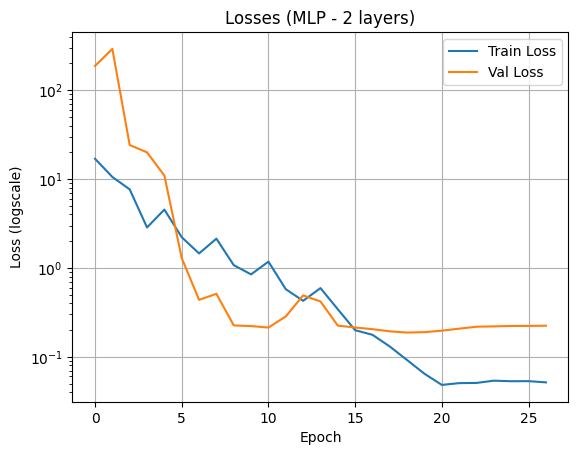

In [11]:
plot_loss(
    train_losses=(train_losses),
    val_losses=(val_losses),
    log=True,
    title="Losses (MLP - 2 layers)",
)

In [12]:
from MatrixVectorizer import MatrixVectorizer

from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import networkx as nx
import numpy as np
import torch


def evaluation_metrics(pred, true, print: bool = False):

    mae_bc = []
    mae_ec = []
    mae_pc = []

    pred_1d_list = []
    gt_1d_list = []

    num_test_samples = len(pred)
    # Iterate over each test sample
    for i in range(num_test_samples):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred[i], edge_attr="weight")
        gt_graph = nx.from_numpy_array(true[i], edge_attr="weight")

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_pc_values = list(pred_pc.values())

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_pc_values = list(gt_pc.values())

        # Compute MAEs
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

        # Vectorize matrices
        pred_1d_list.append(MatrixVectorizer.vectorize(pred[i]))
        gt_1d_list.append(MatrixVectorizer.vectorize(true[i]))

    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute metrics
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    if print:
        print("MAE: ", mae)
        print("PCC: ", pcc)
        print("Jensen-Shannon Distance: ", js_dis)
        print("Average MAE betweenness centrality:", avg_mae_bc)
        print("Average MAE eigenvector centrality:", avg_mae_ec)
        print("Average MAE PageRank centrality:", avg_mae_pc)

    return {
        "mae": mae,
        "pcc": pcc,
        "js_dis": js_dis,
        "avg_mae_bc": avg_mae_bc,
        "avg_mae_ec": avg_mae_ec,
        "avg_mae_pc": avg_mae_pc,
    }


@torch.no_grad()
def evaluate_model(model, dataloader):
    """
    Runs forward pass, calculates binary predictions (threshold=0.5),
    and returns the accuracy score.
    """

    model.eval()

    preds = []
    true = []
    for batch in dataloader:
        inputs, targets = batch
        inputs.to(model.device)
        outputs = model(inputs)
        preds = preds + [p.detach().cpu().numpy() for p in outputs]
        true = true + [p.detach().cpu().numpy() for p in targets]

    batch_metrics = evaluation_metrics(preds, true)
    # Convert to python float
    batch_metrics = {k: float(v) for k, v in batch_metrics.items()}

    return batch_metrics

In [13]:
## Evaluation metrics


eval_metrics = evaluate_model(
    model,
    data_module.val_dataloader(),
)

print(eval_metrics)

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

In [ ]:
import json

with open("outputs/mlp/eval_metrics.json", "w") as f:
    json.dump({k: float(v) for k, v in eval_metrics.items()}, f)

In [18]:
from MatrixVectorizer import MatrixVectorizer
import pandas as pd


@torch.no_grad()
def predict(model, dataloader):
    model.eval()

    preds = []
    for batch in dataloader:

        inputs = batch.squeeze(0)
        inputs.to(model.device)
        outputs = model(inputs)
        for o in outputs:
            preds.append(o.detach().cpu().numpy())

    # Vectorize matrices
    preds = [MatrixVectorizer.vectorize(p) for p in preds]
    preds = np.array(preds)

    # Submission format
    print(preds.shape)
    submission_df = pd.DataFrame(
        {"ID": range(1, len(preds.flatten()) + 1), "Predicted": preds.flatten()}
    )
    submission_df.to_csv("outputs/mlp/submission.csv", index=False)

In [15]:
import importlib
import slim

importlib.reload(slim)
from slim import create_test_dataloader

In [16]:
test_dataloader = create_test_dataloader(data_dir="./data", batch_size=32)

In [19]:
predict(model, test_dataloader)

(112, 35778)


In [20]:
pd.read_csv("outputs/mlp/submission.csv")

,ID,Predicted
0,1,0.264790
1,2,0.405350
2,3,0.480338
3,4,0.411738
4,5,0.494922
...,...,...
4007131,4007132,-0.066432
4007132,4007133,0.388003
4007133,4007134,0.110855
4007134,4007135,0.267968


In [ ]:
pd.read_csv("data/sample_submission.csv")

,ID,Predicted
0,1,0.785341
1,2,0.668988
2,3,0.580687
3,4,0.372283
4,5,0.940133
...,...,...
4007131,4007132,0.424466
4007132,4007133,0.581458
4007133,4007134,0.653392
4007134,4007135,0.368890
